# Integral

**Task:** Write MPI based (mpi4py) python script that numerically calculates the integral of an arbitrary function f(x) (x ∊ R1). Make discretization of x sufficiently large to be able elicit speed up from the parallel computation.

Steps:

1. Set the number of processes and the amount of discretization points

2. Distribute distinct regions of x to each process and find local integrals

3. Call the Reduce routine from MPI to sum up the local integrals and get the final result

4. Check the result with the analytical formula


CRITERIA:

1. Implement the non-parallel version of the integral calculation function (*1 point*)

2. Implement parallel MPI version using mpi4py (*2 points*)

3. Achieve speed up > 1.5 with 2 process parallel version vs. 1 process sequential version  (*2 points*)

4. Plot speedup vs. number of processes (*2 points*)

5. Check the correctness of the calculation results (*2 points*)

In [1]:
!pip install mpi4py

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams["font.size"] = 14

 *   Take $S = \displaystyle \int_a^b  \displaystyle x \, dx$, where $a = 0$ and $b = 1$

 * Trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$

Algorithm:
1. Each process calculates "its" interval of
integration.
2. Each process estimates the integral of *f(x)*
over its interval using the trapezoidal rule.
3. (Reduce) Each process != 0 sends its integral to 0.
4. Process 0 sums the calculations received from
the individual processes and prints the result.
The number of processes (p) should evenly divide
the number of trapezoids


In [3]:
# Compute analytically the value of S
def g(x):
  return np.exp(x)

a = 0.0
b = 1.0
n = 1024

print(f"Analytical solution of the integral S: {g(b) - g(a)}")

Analytical solution of the integral S: 1.718281828459045


In [4]:
# Integral function
def f(x):
  return np.exp(x)

# Serial trapezoidal rule
def trapezoidal_approximation(a, b, n, h):
  integral = (f(a) + f(b))/2.0
  x = a
  for i in range(1, int(n)):
    x = x+h
    integral = integral + f(x)

  return integral*h

In [5]:
# Compute the integral using trapezoidal rule

h = (b - a)/n

integration_error = np.abs(trapezoidal_approximation(a,b,n,h) - (g(b) - g(a)))
discretization_size = (b - a) / (n - 1)
print("Solution of the integral S using trapezoidal approximation: ", trapezoidal_approximation(a,b,n,h))
print("Integration error: ", integration_error)
print("Discretization size", discretization_size)

Solution of the integral S using trapezoidal approximation:  1.7182819650158134
Integration error:  1.3655676833757013e-07
Discretization size 0.0009775171065493646


In [6]:
%%writefile integral.py

from mpi4py import MPI
import numpy as np

def f(x):
  return (1 / np.sqrt(1+ x*x))

def trapezoidal_approximation(a, b, n, h):
  integral = (f(a) + f(b))/2.0
  x = a
  for i in range(1, int(n)):
    x = x+h
    integral = integral + f(x)

  return integral*h

comm = MPI.COMM_WORLD
p = comm.Get_size()
rank = comm.Get_rank()

a = 0.0
b = 1.0
n = 1024
total = -1.0

if rank == 0:
  start = MPI.Wtime()

h = (b - a)/ n
local_n = n / p

local_a = a + rank*local_n*h
local_b = local_a + local_n*h
integral = trapezoidal_approximation(local_a, local_b, local_n, h)

total = comm.reduce(integral)

if (rank == 0):
  end = MPI.Wtime()
  print((end-start))

Overwriting integral.py


In [7]:
!mpiexec -n 4 --allow-run-as-root --oversubscribe python integral.py

0.025163636


In [8]:
execution_time = []
N_processes = [1, 2, 4, 8, 16, 32, 64]
for i in N_processes:
  add = !mpiexec -n {i} --allow-run-as-root --oversubscribe python integral.py
  t = add[0]
  execution_time.append(float(t))
  print(f"{i} Processes execution time {t}s.")

1 Processes execution time 0.001399952s.
2 Processes execution time 0.093974535s.
4 Processes execution time 0.039775209s.
8 Processes execution time 0.027694942s.
16 Processes execution time 0.041949636s.
32 Processes execution time 0.6299068059999999s.
64 Processes execution time 0.952500684s.


In [9]:
speedups = list(execution_time[0] / np.array(execution_time))
efficiencies = list((execution_time[0] / np.array(execution_time))/N_processes)

print(f"Execution times: {execution_time}")
print(f"Speedups: {speedups}")
print(f"Efficiency: {efficiencies}")

Execution times: [0.001399952, 0.093974535, 0.039775209, 0.027694942, 0.041949636, 0.6299068059999999, 0.952500684]
Speedups: [1.0, 0.014897142082160876, 0.03519659695565648, 0.050549013606888946, 0.033372208521666315, 0.002222474795739864, 0.0014697648238119272]
Efficiency: [1.0, 0.007448571041080438, 0.00879914923891412, 0.006318626700861118, 0.0020857630326041447, 6.945233736687075e-05, 2.2965075372061363e-05]


#### Again, just like in the previous task, we can not see a good parallelism result due to Colab being able to run multiple processes MPI programs only with fake parallelism because of the `--oversubscribe` flag.

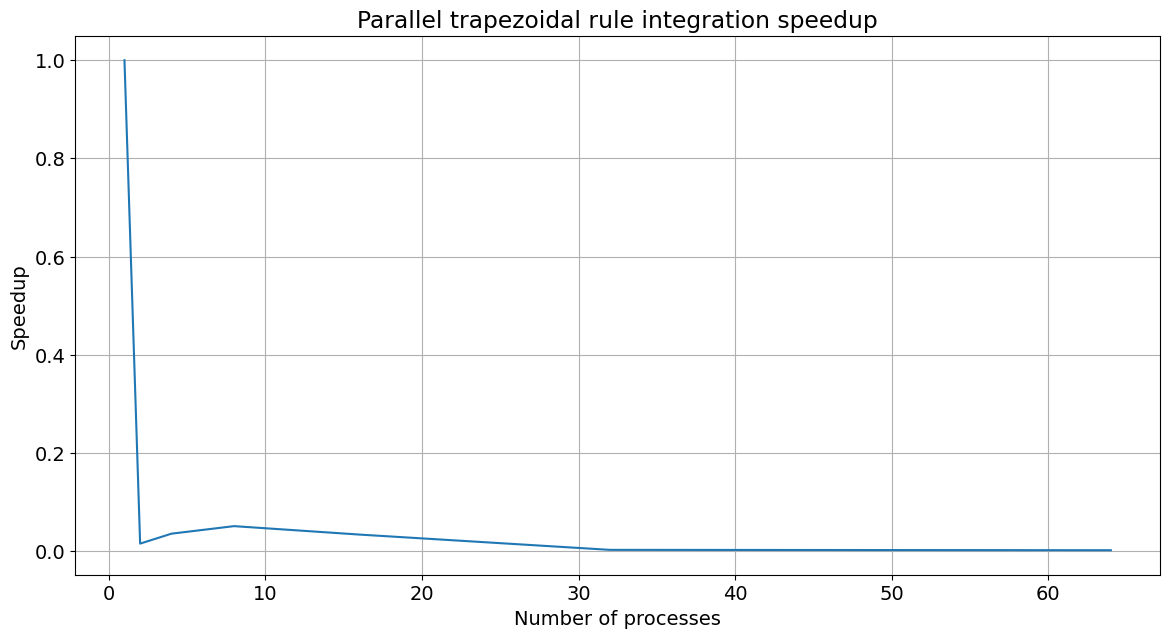

In [10]:
#Plot the speedup vs number of processors
plt.plot(N_processes, speedups)
plt.title('Parallel trapezoidal rule integration speedup')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)

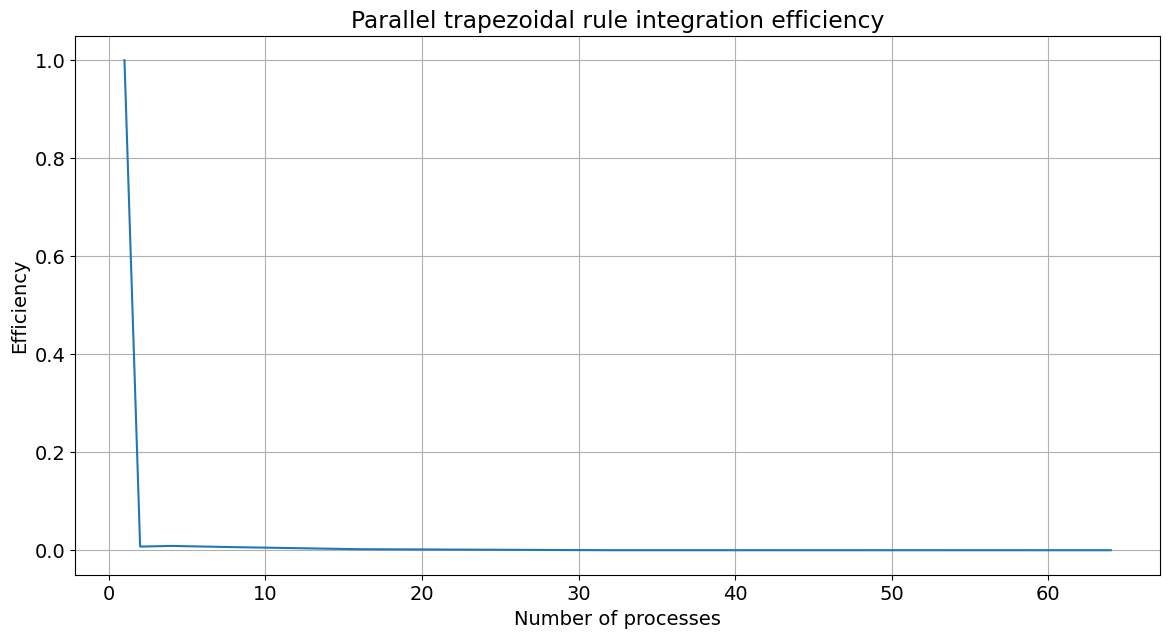

In [11]:
#Plot the speedup vs number of processors
plt.plot(N_processes,  efficiencies)
plt.title('Parallel trapezoidal rule integration efficiency')
plt.xlabel('Number of processes')
plt.ylabel('Efficiency')
plt.grid(True)

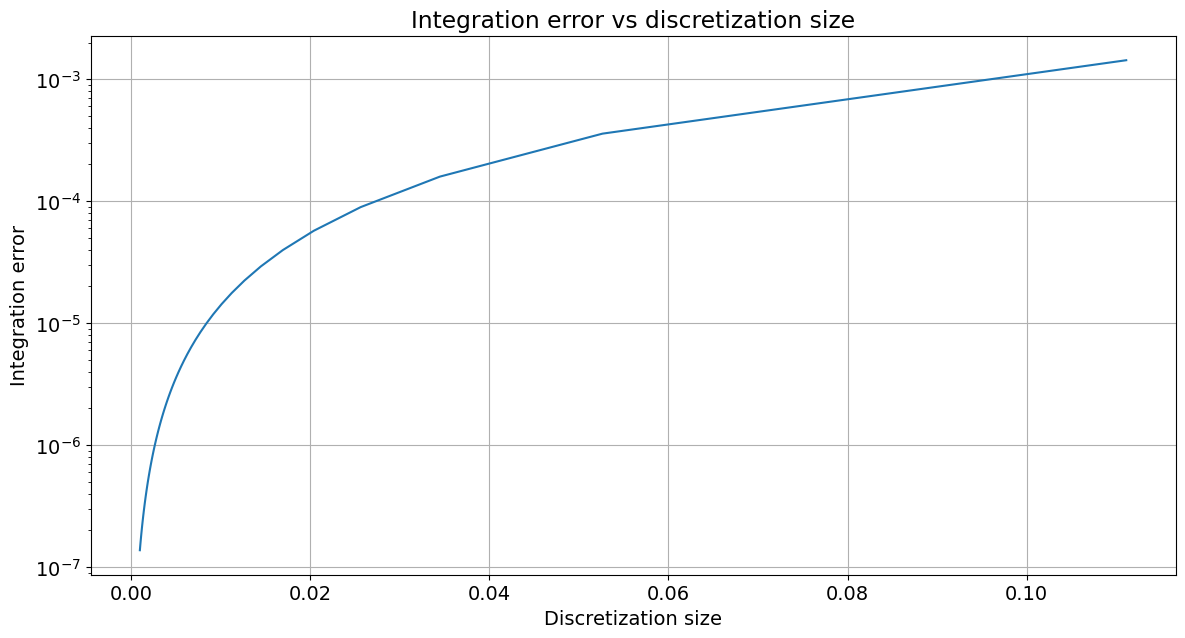

In [12]:
# Plot integration error vs the discretization size
integration_error = []
discretization_size = []
for i in range(10,n,10):
  h = (b - a)/i
  integration_error.append(np.abs(trapezoidal_approximation(a,b,i,h) - (g(b) - g(a))))
  discretization_size.append((b - a) / (i - 1))

plt.semilogy(discretization_size, integration_error)
plt.title('Integration error vs discretization size')
plt.xlabel('Discretization size')
plt.ylabel('Integration error')
plt.grid(True)